In [1]:
import ugradio
import ugradio.coord
import astropy.coordinates
import astropy.time
import time
import numpy as np
import matplotlib.pylab as plt
import inspect
import collections
from scipy.interpolate import interp1d
# import emcee

Error loading librtlsdr. Make sure librtlsdr (and all of its dependencies) are in your path


In [2]:
samp_freq = 500 * 1000 * 1000 # Hz

fname = f'../combined_data/sun/full_day_sun_740am.npy'
data = np.load(fname, allow_pickle=True).tolist()
all_data = {}
for k in data[0].keys():
    all_data[k] = [d.get(k) for d in data]

In [3]:
data[-1]['time']

1678489225.9726708

In [4]:
data[-1]['time']

1678489225.9726708

In [5]:
total_duration = (data[-1]['time']-data[0]['time'])/60
print(total_duration)

438.8556294997533


In [6]:
print(str((all_data['time'][-1] - all_data['time'][0])/60) + ' min')

438.8556294997533 min


In [7]:
def fft(data, num_samp=1024, samp_rate=samp_freq):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

In [22]:
def rchisq(model, Y, cov, num_p):
    '''
    model = predicted model 
    Y = reality Y values
    cov = cov matrix
    num_p = number of fitted parameters
    '''
    deg = len(model) - num_p 
    return 1/deg * np.sum(np.abs(Y - model)**2)# / np.sum(np.diag(cov))) 

# data

In [9]:
visibility = all_data['corr01'] - np.mean(all_data['corr01'], axis=0, keepdims=True)
freqs = np.fft.fftshift(np.fft.fftfreq(1024, 1/500)) + 1540
visibility = visibility[:, 400:900]
times = np.array(all_data['time'])
C = 299792458 # m/s
LO = 8.75e9 + 1.54e9
freqs = np.linspace(0, 250e6, 1024, endpoint=False) + LO
freqs = freqs[400:900]

def convert_index_to_freq(index):
    assert index >= 0 and index <= 500, 'incorrect index'
    

visibility.shape

(21020, 500)

# Visibility

(9000.0, 8000.0)

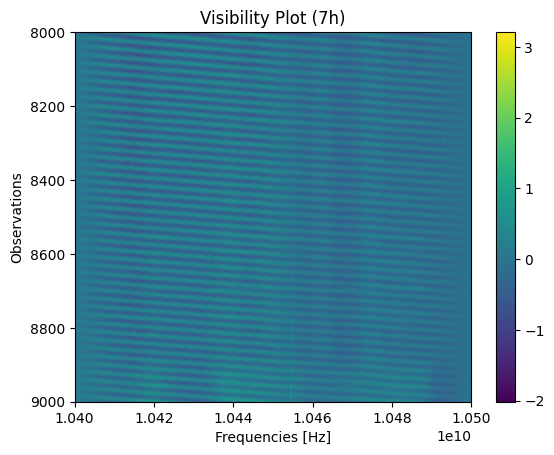

In [148]:
# plt.figure(figsize=(8,20))
plt.imshow(visibility.real, aspect='auto', extent=[freqs[0], freqs[-1], len(visibility), 0])
plt.colorbar()
plt.title('Visibility Plot (7h)')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Observations')
plt.xlim(1.04e10, 1.05e10)
plt.ylim(9000, 8000)

c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


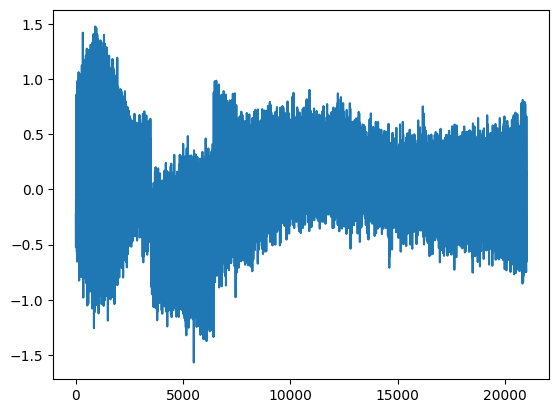

In [11]:
plt.plot(visibility[:,250])
# plt.xlim(5000,5100)

angle plot?

Text(0.5, 1.0, 'Angle Plot')

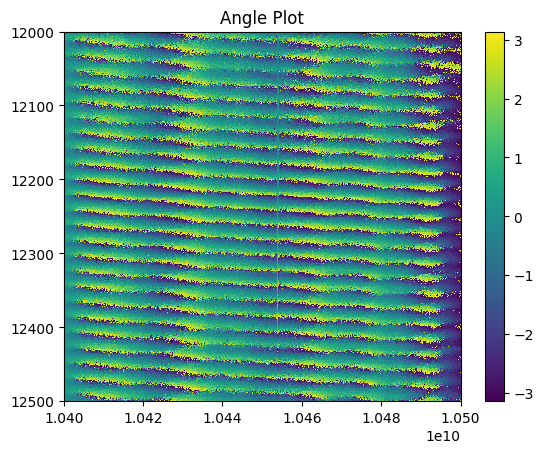

In [12]:
# plt.figure(figsize=(8,20))
plt.imshow(np.angle(visibility), extent=[freqs[0], freqs[-1], len(visibility), 0], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlim(1.04e10, 1.05e10)
plt.ylim(12500, 12000)
plt.title('Angle Plot')

# fft of the data

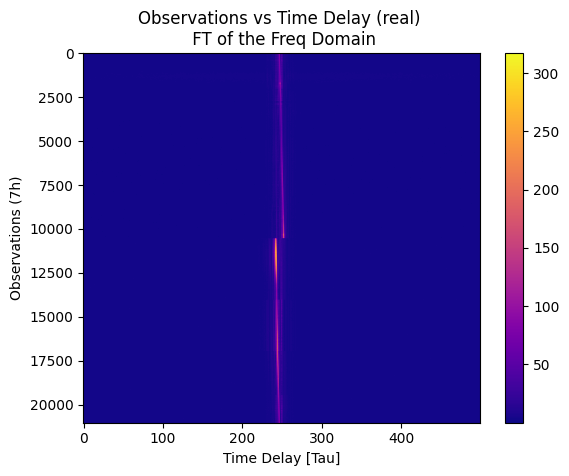

In [13]:
ftfreq = np.fft.fftshift(np.fft.fft(visibility, axis=1))
ffreq2 = np.fft.fft(all_data['corr01'], axis=1)

plt.figure()
plt.imshow(np.abs(ftfreq), aspect='auto', cmap='plasma')
plt.xlabel('Time Delay [Tau]')
plt.ylabel('Observations (7h)')
plt.title('Observations vs Time Delay (real) \n FT of the Freq Domain')
plt.colorbar()
# plt.xlim(450, 550)
# plt.ylim(12500, 10000)
plt.show()

NOT airy ring
airy ring = ring of the sun

fft2 of the data


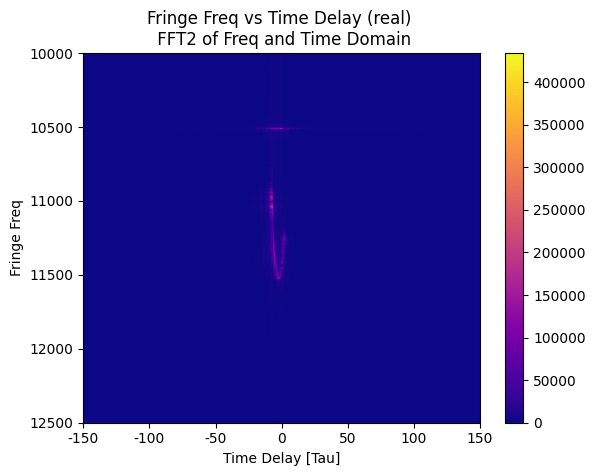

In [14]:
ftfreq = np.fft.fftshift(np.fft.fft2(visibility))
ffreq2 = np.fft.fft(all_data['corr01'], axis=1)

plt.figure()
plt.imshow(np.abs(ftfreq), aspect='auto', cmap='plasma')
plt.xlabel('Time Delay [Tau]')
plt.ylabel('Fringe Freq')
plt.title('Fringe Freq vs Time Delay (real) \n FFT2 of Freq and Time Domain')
plt.colorbar()
plt.xticks(range(0, len(ftfreq[0]), 50), range(-250, 250, 50))
plt.xlim(100, 400)
plt.ylim(12500, 10000)
plt.show()

something

plotting the power (after FT) of a given freq slice

what r the x and y axes?

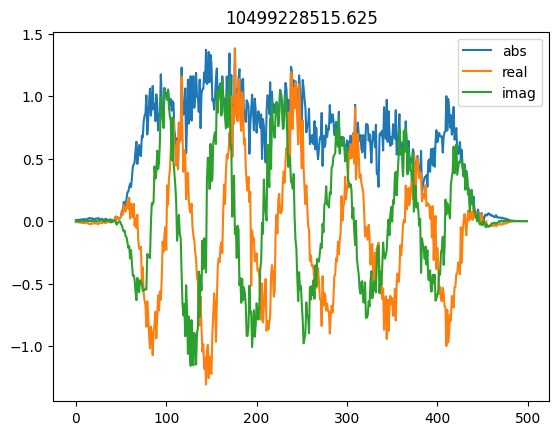

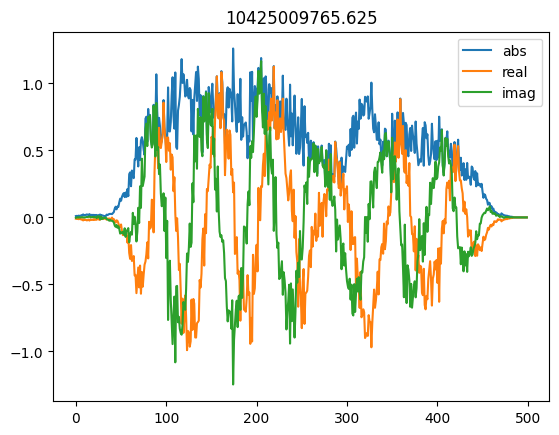

In [15]:
# attempt to create the sin func on the board in a single freq channel

def plot2():
    result = []
    for f in sorted(np.random.choice(freqs, size=1)):
        Y = visibility[np.argwhere(freqs <= f)[-1, 0]]
        result = np.append(result, Y)
        plt.title(f'{str(f)}')
        plt.plot(np.abs(Y), label=f'abs')
        plt.plot(Y.real, label=f'real')
        plt.plot(Y.imag, label=f'imag')
    # plt.xlim(400, 850) 
    plt.legend()
    plt.show()
    return result
_ = plot2()
_ = plot2()

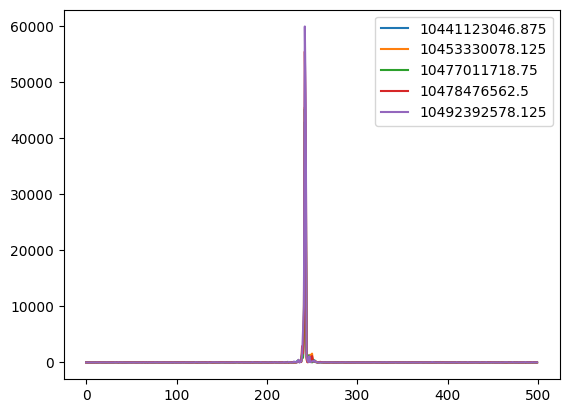

In [16]:
def plot1():
    result = []
    for f in sorted(np.random.choice(freqs, 5)):
        Fx = np.fft.fftshift(np.fft.fft(visibility[np.argwhere(freqs <= f)[-1][0]]))
        result = np.append(result, Fx)
        plt.plot(np.abs(Fx)**2, label=str(f))
        # break
    plt.legend()
    return result
_ = plot1()

In [17]:
def baseline(ew, ns, ud):
    return np.array([ew, ns, ud], dtype=float)

# fitting

## brute force initial guess 

In [18]:
def vtg(baseline, freq, time):
    C = 299792458
    
    # terrestrial latitude
    L = ugradio.nch.lat
    
    b_ew = baseline[0]
    b_ns = baseline[1]
    lamb = C / freq
    
    ra = np.array([])
    dec = np.array([])
    
    # time
    jd_time = ugradio.timing.julian_date(time)
    for t in np.squeeze([jd_time]):
        sun_radec = ugradio.coord.sunpos(t)
        r, d = np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1])
        ra, dec = np.append(ra, r), np.append(dec, d)
    
    # hour angle
    theta = np.pi/2 - dec
    h_s = theta
    
    # declination
    delta = dec
    
    result = b_ew / lamb * np.cos(delta) * np.sin(h_s) + b_ns / lamb * np.sin(L) * np.cos(delta) * np.cos(h_s)
    return result
    
def big_F(vtg, A, B):
    result = A * np.cos(2 * np.pi * vtg) + B * np.sin(2 * np.pi * vtg)
    return result

In [38]:
from scipy.optimize import curve_fit

f = 250

B_ew, B_ns = np.linspace(13,16,4), np.linspace(0,3,3)
B_ew, B_ns = np.meshgrid(B_ew, B_ns)
# print(B_ew)
rchisq_dict = {}
for b_ew in B_ew[0]:
    for b_ns in B_ns[:,0]:
        vtg_comp = vtg(baseline(b_ew, b_ns, 0.), freqs[f], times)
        ydata = visibility[:, f]
        popt, pcov = curve_fit(big_F, xdata=vtg_comp, ydata=ydata, p0=[0.0003, 0.0003])
        rchisq_comp = rchisq(big_F(vtg_comp, popt[0], popt[1]), ydata, pcov, len(popt))
        rchisq_dict[(b_ew, b_ns)] = rchisq_comp
        print(f'baseline [{b_ew}, {b_ns}]: {rchisq_comp}')
print(rchisq_dict)

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


baseline [13.0, 0.0]: 0.2904413611749943
baseline [13.0, 1.5]: 0.290424740018584
baseline [13.0, 3.0]: 0.2904054137596535
baseline [14.0, 0.0]: 0.2904319964757246
baseline [14.0, 1.5]: 0.2904139220282399
baseline [14.0, 3.0]: 0.290393092802158
baseline [15.0, 0.0]: 0.2904218539684105
baseline [15.0, 1.5]: 0.29040229550474406
baseline [15.0, 3.0]: 0.29037992360415754
baseline [16.0, 0.0]: 0.29041091440847355
baseline [16.0, 1.5]: 0.2903898370416102
baseline [16.0, 3.0]: 0.2903658788728529
{(13.0, 0.0): 0.2904413611749943, (13.0, 1.5): 0.290424740018584, (13.0, 3.0): 0.2904054137596535, (14.0, 0.0): 0.2904319964757246, (14.0, 1.5): 0.2904139220282399, (14.0, 3.0): 0.290393092802158, (15.0, 0.0): 0.2904218539684105, (15.0, 1.5): 0.29040229550474406, (15.0, 3.0): 0.29037992360415754, (16.0, 0.0): 0.29041091440847355, (16.0, 1.5): 0.2903898370416102, (16.0, 3.0): 0.2903658788728529}


In [ ]:
rchisq_dict

{(0.0, 0.0): 0.0,
 (2.2222222222222223, 0.0): 63.49950813851106,
 (4.444444444444445, 0.0): 251.94469505376412,
 (6.666666666666667, 0.0): 559.2645238483063,
 (8.88888888888889, 0.0): 975.6327128231892,
 (11.11111111111111, 0.0): 1487.8905124431658,
 (13.333333333333334, 0.0): 2080.1084689478716,
 (15.555555555555557, 0.0): 2734.259641271334,
 (17.77777777777778, 0.0): 3430.9703616063616,
 (20.0, 0.0): 4150.312366872146}

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = B_ew, B_ns

zs = []
for i in range(len(np.ravel(X))):
    zs = np.append(zs, rchisq_dict.get((np.ravel(X)[i], np.ravel(Y)[i])))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## fringe frequency

- get the fringe freq from FT of vis
- NOTE be wary of 0 spike
- fit using eq 14 in spec
- should produce a simple 2d distribution (parabola) that can be maximized

In [ ]:
def local_fringe_freq(baseline, freq, time):
    C = 299792458
    
    # terrestrial latitude
    L = ugradio.nch.lat
    
    b_ew = baseline[0]
    b_ns = baseline[1]
    lamb = C / freq
    
    ra = np.array([])
    dec = np.array([])
    
    # time
    jd_time = ugradio.timing.julian_date(time)
    for t in np.squeeze([jd_time]):
        sun_radec = ugradio.coord.sunpos(t)
        r, d = np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1])
        ra, dec = np.append(ra, r), np.append(dec, d)
    
    # hour angle
    theta = np.pi/2 - dec
    h_s = theta
    
    # declination
    delta = dec
    
    result = b_ew / lamb * np.cos(delta) * np.cos(h_s) - b_ns / lamb * np.sin(L) * np.cos(delta) * np.sin(h_s)
    return result
    


In [ ]:
fft visibility[:, f]

In [ ]:
from scipy.optimize import curve_fit

f = 250

B_ew, B_ns = np.linspace(13,16,4), np.linspace(0,3,3)
B_ew, B_ns = np.meshgrid(B_ew, B_ns)
# print(B_ew)
rchisq_dict = {}
for b_ew in B_ew[0]:
    for b_ns in B_ns[:,0]:
        vtg_comp = vtg(baseline(b_ew, b_ns, 0.), freqs[f], times)
        ydata = visibility[:, f]
        popt, pcov = curve_fit(big_F, xdata=vtg_comp, ydata=ydata, p0=[0.0003, 0.0003])
        rchisq_comp = rchisq(big_F(vtg_comp, popt[0], popt[1]), ydata, pcov, len(popt))
        rchisq_dict[(b_ew, b_ns)] = rchisq_comp
        print(f'baseline [{b_ew}, {b_ns}]: {rchisq_comp}')
print(rchisq_dict)

## emcee

artificial fringe
- stolen from aaron's demo

In [134]:
# custom rotation matrices


print(times.shape)
jd_time = ugradio.timing.julian_date(times)

def get_rot_full():
    lst0 = ugradio.timing.lst(jd_time[0])
    lst1 = ugradio.timing.lst(jd_time[1])
    lsts = lst0 + np.arange(jd_time.shape[0]) * (lst1 - lst0)
    ones = np.ones_like(lsts)
    #ha = lsts - radec[0]
    rot_eq_ha = np.array([[
        [np.cos(lsts),  np.sin(lsts),     0*ones],
        [np.sin(lsts), -np.cos(lsts),     0*ones],
        [      0*ones,        0*ones,     1*ones],
    ]])
    lat = np.deg2rad(ugradio.nch.lat)
    rot_ha_altaz = np.array([[
        [-np.sin(lat),  0, np.cos(lat)],
        [           0, -1,           0],
        [ np.cos(lat),  0, np.sin(lat)],
    ]])

    rot_full = np.dot(rot_ha_altaz, rot_eq_ha)
    rot_full.shape = (3, 3, -1)
    return rot_full
get_rot_full()

(21020,)


array([[[-0.11918612, -0.11920302, -0.11921993, ..., -0.43403   ,
         -0.43404218, -0.43405437],
        [ 0.60223547,  0.60223212,  0.60222877, ...,  0.43417836,
          0.43416618,  0.434154  ],
        [ 0.78937134,  0.78937134,  0.78937134, ...,  0.78937134,
          0.78937134,  0.78937134]],

       [[ 0.98097368,  0.98096823,  0.98096278, ...,  0.70722761,
          0.70720776,  0.70718792],
        [ 0.19414076,  0.19416829,  0.19419582, ...,  0.70698594,
          0.70700578,  0.70702563],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.15324915,  0.15327088,  0.15329261, ...,  0.55807444,
          0.5580901 ,  0.55810577],
        [-0.77435251, -0.77434821, -0.77434391, ..., -0.5582652 ,
         -0.55824954, -0.55823388],
        [ 0.61391603,  0.61391603,  0.61391603, ...,  0.61391603,
          0.61391603,  0.61391603]]])

In [135]:
# acquiring sun positons for recorded times

def get_sun_pos_top():

    sun_radec = ugradio.coord.sunpos(jd_time[0])
    radec = (np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1]))
    theta = np.pi/2 - radec[1]
    phi = radec[0]
    sun_z = np.cos(theta)
    r_xy = np.sin(theta)
    sun_x = r_xy * np.cos(phi)
    sun_y = r_xy * np.sin(phi)
    sun_pos_eq = np.array([sun_x, sun_y, sun_z])
    sun_pos_top = np.dot(sun_pos_eq, get_rot_full())
    # print(sun_pos_top.shape)
    sun_pos_top = np.array([sun_pos_top[1], sun_pos_top[0], sun_pos_top[2]])
    # print(sun_pos_top.shape)
    return sun_pos_top

sun_pos_top = get_sun_pos_top()
    

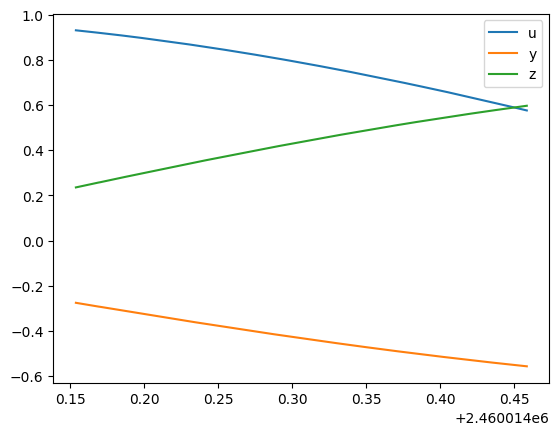

In [136]:
plt.figure()
plt.plot(jd_time, sun_pos_top[0], label='u')
plt.plot(jd_time, sun_pos_top[1], label ='y')
plt.plot(jd_time, sun_pos_top[2], label ='z')
plt.legend()

In [137]:
# generating fringe

def get_fringe(baseline, freq=250):
    fq = freqs[freq] 
    b_proj = np.dot(baseline, sun_pos_top)
    lam = C / fq
    w = b_proj / lam
    fringe = np.exp(-2*np.pi*1j*w)
    fringe = np.where(sun_pos_top[2] > 0, fringe, 0)
    return fringe


(0.0, 1000.0)

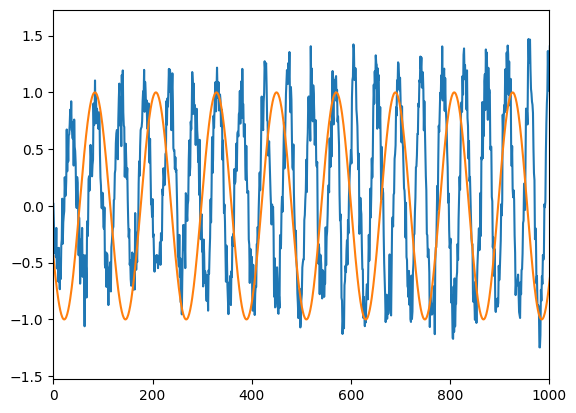

In [23]:
f = 250

plt.figure()
plt.plot(visibility[:,f])
plt.plot(get_fringe(baseline(20., 2, 0), freq=f))
plt.title(f'{freqs[f] * 1e-9} MHz')
plt.xlim(0,1000)

model

- monte carlo markov chains 

In [102]:
f = 250

def log_likelihood(theta, x, y):                                  # revise 
    model = get_fringe(baseline(theta[0], theta[1], 0), f)
    
    yerr2 = np.mean(np.abs(y - np.mean(y))**2)
    sigma2 = yerr2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

y = visibility[:, f]
x = range(len(y))

np.random.seed(27)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([15., 3.]) + 0.1 * np.random.randn(2) 
soln = minimize(nll, initial, args=(x, y))    
print(soln.x)                                           # revise 


def log_prior(theta):
    ew, ns = theta
    if 11 < ew < 19 and 0 < ns < 5:       # revise 
        return 0.0
    return -np.inf

def log_probability(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y)

import emcee

pos = (soln.x + 1e-1 * np.random.randn(32, 2)) 
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y)
)
sampler.run_mcmc(pos, 20000, progress=True);    

mean_result = np.mean(sampler.chain, axis=1)

c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\scipy\optimize\_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\emcee\ensemble.py:495: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l) for l in results])


[16.09485836  2.60280678]


100%|██████████| 20000/20000 [17:01<00:00, 19.57it/s]


chain plot

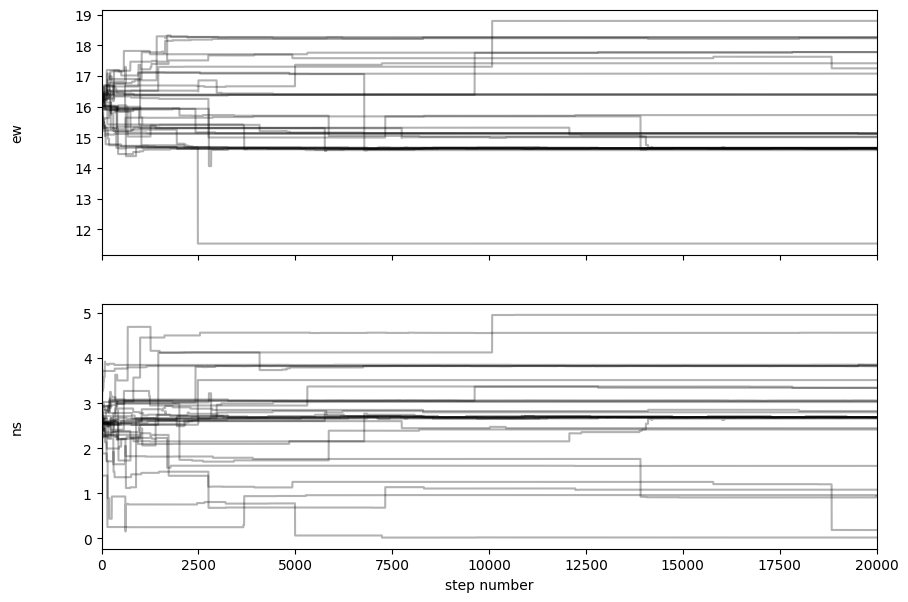

In [104]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["ew", "ns"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

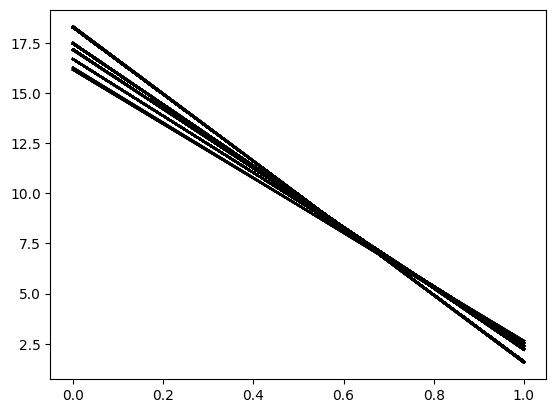

In [105]:
res=plt.plot(sampler.chain[0,:,:].T, '-', color='k', alpha=0.3)

autocorr time

In [125]:
tau = sampler.get_autocorr_time()
print(tau)

NameError: name 'sampler' is not defined

In [ ]:
flat_samples = sampler.get_chain(discard=3200, thin=800, flat=True)
print(flat_samples.shape)

(672, 2)


corner plot 
- get the max of the dist using sd

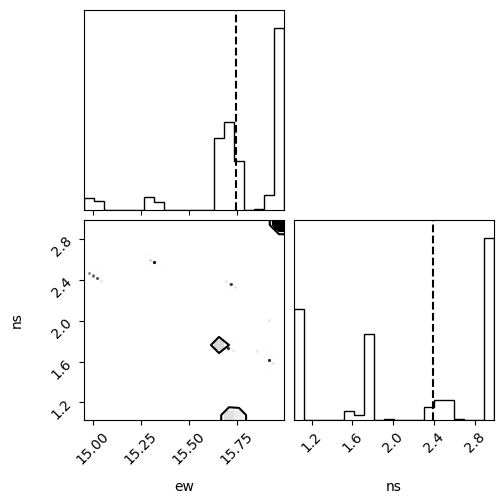

In [108]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.5]#, truths=[m_true, b_true, np.log(f_true)]
);

In [109]:
def get_quantiles(data):
    result = {}
    for i in range(data.shape[1]):
        _16 = np.quantile(data[:, i], .16)
        _50 = np.quantile(data[:, i], .5)
        _84 = np.quantile(data[:, i], .84)
        result[i] = [_50 - _16, _50, _84 - _50]
    return result
get_quantiles(flat_samples)

{0: [0.06686900369340165, 15.747333359705738, 0.22431884436979388],
 1: [1.3052244992135844, 2.38647272134307, 0.5966080682111294]}

## check fit 

In [132]:
b_est = baseline(15.747333359705738, 2.38647272134307, 0)

c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'vis[:, 200]')

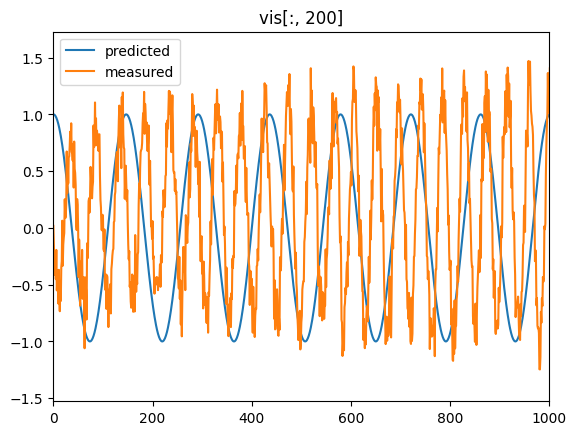

In [139]:
plt.plot(get_fringe(baseline=b_est, freq=200), label='predicted')
plt.plot(visibility[:, 200], label='measured')
plt.legend()
plt.xlim(0,1000)
plt.title('vis[:, 200]')

c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


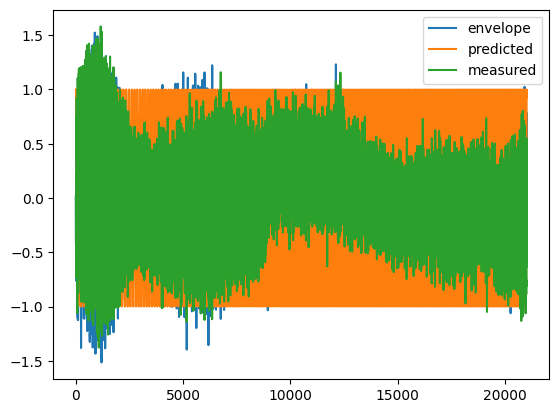

In [141]:
Y = visibility[:, 200]
y_hat = get_fringe(baseline=b_est, freq=200)
plt.plot(Y * np.conjugate(y_hat), label='envelope')
plt.plot(y_hat, label='predicted')
plt.plot(Y, label='measured')
plt.legend()
# plt.xlim(0,1000)

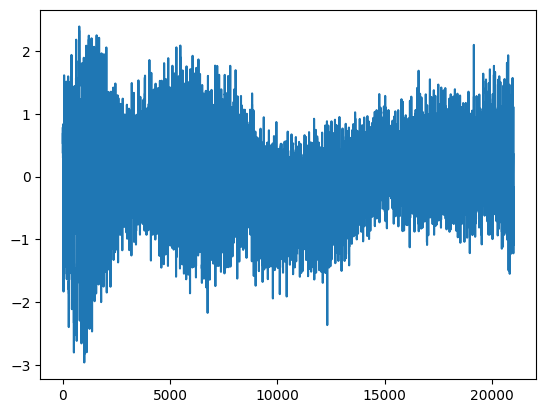

In [27]:
plt.plot(Y * np.conjugate(y_hat) - Y, label='envelope')
# plt.plot(Y, label='measured')

# radius of sun

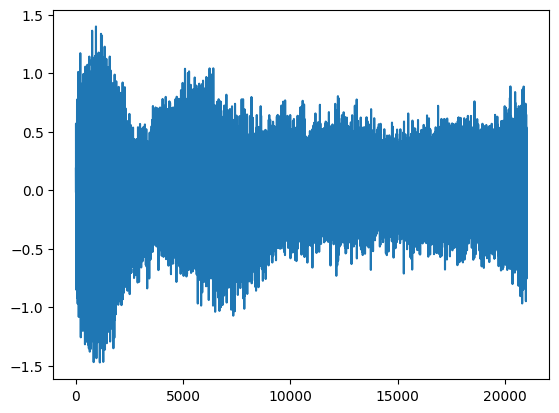

In [18]:
f = 100
plt.plot(visibility[:,f])


In [19]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

In [20]:
def convert_time_to_ha(time):
    ra = np.array([])
    dec = np.array([])
    
    # time
    jd_time = ugradio.timing.julian_date(time)
    for t in np.squeeze([jd_time]):
        sun_radec = ugradio.coord.sunpos(t)
        r, d = np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1])
        ra, dec = np.append(ra, r), np.append(dec, d)
    
    # hour angle
    theta = np.pi/2 - dec
    hour_angle = theta
    return hour_angle

hour_angles = convert_time_to_ha(times)

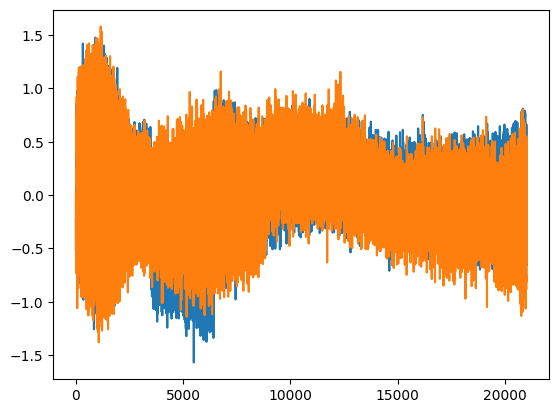

In [175]:
plt.plot(visibility[:,250])
plt.plot(visibility[:,200])

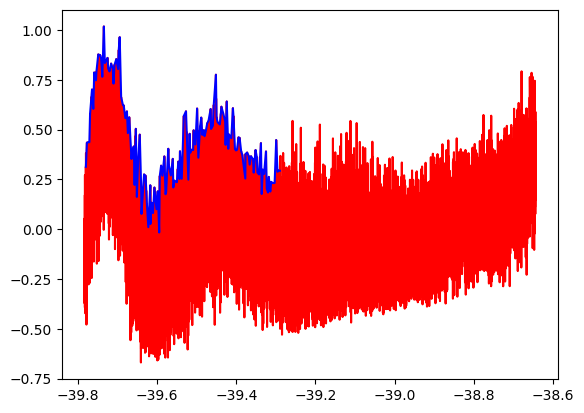

In [253]:
from scipy.special import j1

f = 150
b_est = baseline(15.747333359705738, 2.38647272134307, 0)

def convert_ha_to_u(hour_angle):
    C = 299792458
    lamb = C / freqs[f]  
    b_ew = b_est[0]
    return b_ew / lamb  * np.cos(hour_angle)

v = visibility[:,f]
ydata = np.abs(v)
udata = convert_ha_to_u(hour_angles)
fit = np.polyval(np.polyfit(udata, ydata, 1), udata)
ydata = ydata - fit

d = 20
lmin, lmax = hl_envelopes_idx(ydata, dmin=d,dmax=d)
cut = 150
u_envelope = udata[lmax][:cut]
y_envelope = ydata[lmax][:cut]

# plot y - fit
plt.plot(udata, ydata, color='red', label='original - fit')
plt.plot(u_envelope, y_envelope, color='blue', label='envelope')

In [254]:
def fit_bessel(u, r, A, B, C):
    x = 2 * np.pi * u * r
    return A * np.abs(j1(x - C) / (x - C)) + B

from scipy.optimize import curve_fit

np.random.seed(27)
initial = np.array([.9, .2, 1, 0.00872665])
popt, pcov = curve_fit(fit_bessel, xdata=u_envelope, ydata=y_envelope, p0=initial)
y_result = fit_bessel(u_envelope, popt[0], popt[1], popt[2], popt[3])
rchisq_comp = rchisq(y_result, y_envelope, pcov, len(popt))
print(f'rchisq: {rchisq_comp}')    
print(f'r_sun: {popt[0]}')  

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

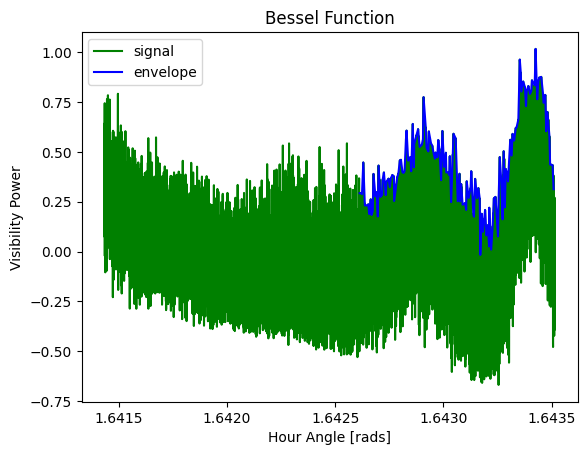

In [255]:
# plot
plt.plot(hour_angles, ydata,'g',label='signal')
plt.plot(hour_angles[lmax][:cut], y_envelope, 'b', label='envelope')
plt.xlabel('Hour Angle [rads]')
plt.ylabel('Visibility Power')
plt.title('Bessel Function')
plt.legend()


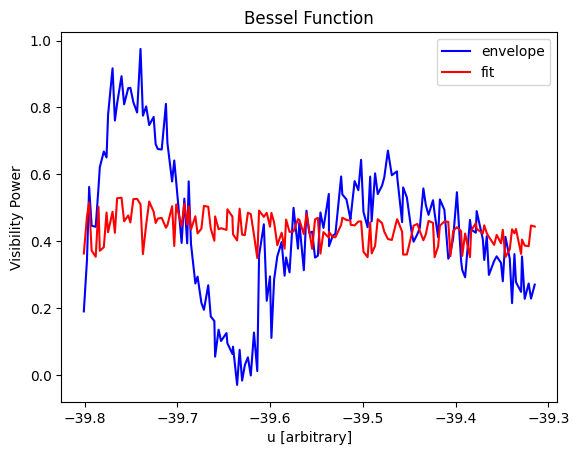

In [251]:
# plot
# plt.plot(hour_angles, ydata,'g',label='signal')
plt.plot(u_envelope, y_envelope, 'b', label='envelope')
plt.plot(u_envelope, y_result, 'r', label='fit')
plt.xlabel('u [arbitrary]')
plt.ylabel('Visibility Power')
plt.title('Bessel Function')
plt.legend()

In [177]:
np.sqrt(np.diag(pcov))

array([4.19860295e-02, 1.71320245e+03, 3.01984032e-02, 1.04233830e+01])